In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import transformers as ppb
import torch

from sklearn.metrics import confusion_matrix,classification_report,roc_curve,roc_auc_score
from sklearn.metrics import precision_recall_curve,f1_score
import matplotlib.pyplot as plt
import seaborn as sns


from tqdm import tqdm
tqdm.pandas()

import warnings
warnings.filterwarnings('ignore')

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

In [3]:
df = pd.read_csv('https://github.com/clairett/pytorch-sentiment-classification/raw/master/data/SST2/train.tsv', delimiter='\t', header=None)

In [4]:
df.columns = ['text','labels']

In [5]:
df = df.iloc[:4000]
df.head()

,text,labels
0,"a stirring , funny and finally transporting re...",1
1,apparently reassembled from the cutting room f...,0
2,they presume their audience wo n't sit still f...,0
3,this is a visually stunning rumination on love...,1
4,jonathan parker 's bartleby should have been t...,1


In [6]:
# For DistilBERT:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

In [7]:
# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [8]:
tokenized = df['text'].progress_apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

100%|██████████| 4000/4000 [00:02<00:00, 1583.01it/s]


In [9]:
tokenized[:5]

0    [101, 1037, 18385, 1010, 6057, 1998, 2633, 182...
1    [101, 4593, 2128, 27241, 23931, 2013, 1996, 62...
2    [101, 2027, 3653, 23545, 2037, 4378, 24185, 10...
3    [101, 2023, 2003, 1037, 17453, 14726, 19379, 1...
4    [101, 5655, 6262, 1005, 1055, 12075, 2571, 376...
Name: text, dtype: object

In [10]:
max_len = 0
for tokenized_array_i in tokenized:
    if len(tokenized_array_i)> max_len:
        max_len=len(tokenized_array_i)
max_len

66

In [11]:
len(tokenized[0]),len(tokenized[0]+[0]*(max_len-len(tokenized[0])))

(20, 66)

In [12]:
padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

In [13]:
np.array(padded).shape

(4000, 66)

In [14]:
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(4000, 66)

In [15]:
padded_torch = torch.tensor(padded)  
attention_mask_torch = torch.tensor(attention_mask)

In [16]:
padded_torch[0].shape

torch.Size([66])

In [17]:
with torch.no_grad():
    last_hidden_states_torched = model(padded_torch, attention_mask=attention_mask_torch)

In [18]:
last_hidden_states_torched[0].shape

torch.Size([4000, 66, 768])

In [19]:
last_hidden_states_torched[0][0].shape

torch.Size([66, 768])

In [20]:
features = last_hidden_states_torched[0][:,0,:].numpy()

In [21]:
features[:5]

array([[-0.21593429, -0.14028913,  0.00831074, ..., -0.13694832,
         0.5867007 ,  0.2011271 ],
       [-0.17262723, -0.14476165,  0.00223429, ..., -0.17442542,
         0.21386448,  0.3719747 ],
       [-0.05063359,  0.07203981, -0.02959722, ..., -0.07148949,
         0.718524  ,  0.26225471],
       [-0.14749788,  0.06445155, -0.00369915, ..., -0.07814704,
         0.4238375 ,  0.23188193],
       [-0.0654161 ,  0.06376418,  0.02759007, ..., -0.02262597,
         0.47929966,  0.39116073]], dtype=float32)

In [22]:
df_final = pd.DataFrame(features)

In [23]:
df_final.columns = [f"feature_{i+1}"for i in range(len(df_final.columns))]

In [24]:
df_final.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_759,feature_760,feature_761,feature_762,feature_763,feature_764,feature_765,feature_766,feature_767,feature_768
0,-0.215934,-0.140289,0.008311,-0.101173,-0.098800,-0.092581,0.187413,0.308779,-0.079129,-0.144936,...,0.007209,-0.291156,-0.136476,-0.077851,0.071078,0.063628,0.084097,-0.136948,0.586701,0.201127
1,-0.172627,-0.144762,0.002234,0.030628,0.120575,-0.088869,0.206804,0.255742,-0.114185,-0.007488,...,-0.075452,-0.115842,0.114645,0.047418,0.185320,-0.116279,-0.066597,-0.174425,0.213864,0.371975
2,-0.050634,0.072040,-0.029597,-0.140355,-0.080607,-0.103232,0.426805,0.245678,0.046981,-0.148649,...,-0.211884,-0.249635,-0.037668,-0.227981,-0.072469,0.078502,-0.011735,-0.071489,0.718524,0.262255
3,-0.147498,0.064452,-0.003699,-0.219294,0.060845,-0.064445,0.004213,0.256717,-0.175174,-0.163916,...,0.273039,-0.013068,-0.029533,-0.143953,-0.053300,-0.050167,0.021766,-0.078147,0.423838,0.231882
4,-0.065416,0.063764,0.027590,-0.120538,-0.069055,-0.089218,0.151275,0.308792,-0.281770,0.076272,...,-0.042348,-0.263472,0.030694,-0.024583,0.068632,0.141143,-0.075043,-0.022626,0.479300,0.391161


In [25]:
df_final['labels'] = df.labels.tolist()

In [26]:
x_train, x_test, y_train, y_test = train_test_split(df_final.drop("labels",axis=1), df_final['labels'],random_state=42)

In [27]:
clf = RandomForestClassifier(random_state=42,min_samples_split=100)
clf.fit(x_train, y_train)

RandomForestClassifier(min_samples_split=100, random_state=42)

In [28]:
def get_model_performance(clf,x_train,x_test,y_train,y_test,plot_title="",
                          label_font_size=14):
    
    y_pred = clf.predict(x_test) # get predicted class
    y_test_prob = clf.predict_proba(x_test)[:,1] # get positive class probability (test)
    y_train_prob = clf.predict_proba(x_train)[:,1] # get positive class probability (train)
    print("Classification report at 0.5 threshold")
    print(classification_report(y_test,y_pred))

    fpr_train, tpr_train, th_train = roc_curve(y_train,y_train_prob) # roc curve details train
    fpr_test, tpr_test, th_test = roc_curve(y_test,y_test_prob) # roc curve details test
    
    prob_th_min = 0
    prob_th_max = 1
    prob_th_step = 0.05
    prob_th_ls = np.arange(prob_th_min,prob_th_max,prob_th_step) # prob thres to iterate over

    f1_scores_ls = []

    for prob_th in prob_th_ls:
        y_pred_i = np.where(y_test_prob>prob_th,1,0)
        f1_macro_score_i = f1_score(y_test,y_pred_i,average='macro') # chosing macro as class is imbalanced
        f1_scores_ls.append(f1_macro_score_i) # appending f1 scores for each prob thres
    
    # get optimal prob thres based on f1 scores
    optimal_th_f1_score = prob_th_ls[np.argwhere(np.array(f1_scores_ls)==np.max(f1_scores_ls))[0][0]]
    
    # get precision and recall curve details
    precision_, recall_, prob_th = precision_recall_curve(y_test, y_test_prob)
    # get optimal prob thres based on PR curve
    optimal_prob_pr_th = prob_th[np.argmin(abs(precision_ - recall_))]
    
    plt.figure(figsize=(8,20))
    plt.subplot(611)
    # plto of conf matrix at 0.5 thres
    sns.heatmap(pd.crosstab(y_test,y_pred),annot=True, cmap='gnuplot' ,fmt='d',linecolor='white',\
                cbar=False,linewidths=1)
    plt.xlabel("Predicted",fontsize=label_font_size*0.85)
    plt.ylabel("Actual",fontsize=label_font_size*0.85)
    plt.title(f"{plot_title} Confusion Matrix ",fontsize=label_font_size)
    print("========================================")
    
    plt.subplot(612)
    # ROC plot 
    plt.plot(fpr_train,tpr_train,color='blue',linewidth=2)
    plt.plot(fpr_test,tpr_test,color='red',linewidth=2)
    plt.xlabel("Fasle Positive Rate",fontsize=label_font_size*0.85)
    plt.ylabel("True Positive Rate",fontsize=label_font_size*0.85)
    plt.legend(["Train ROC","Test ROC"])
    plt.title(f"{plot_title} ROC curve AUC Score = {round(roc_auc_score(y_test,y_pred),2)}",
              fontsize=label_font_size)
    plt.grid(True)
    
    plt.subplot(613)
    # Precision Recallplot
    plt.plot(recall_,precision_,color='red',linewidth=2)
    plt.xlabel("Recall",fontsize=label_font_size*0.85)
    plt.ylabel("Precision",fontsize=label_font_size*0.85)
    plt.title(f"Optimal probability threshold = {round(optimal_prob_pr_th,2)}",fontsize=label_font_size)
    plt.grid(True)
    
    
    print("Classification report at optimal threshold from PR curve")
    y_pred_pr_th = np.where(y_test_prob>optimal_prob_pr_th,1,0)
    print(classification_report(y_test,y_pred_pr_th))
    print("========================================")
    
    plt.subplot(614)
    # Confusion matrix at optimal thres from PR curve
    sns.heatmap(pd.crosstab(y_test,y_pred_pr_th),annot=True, cmap='gnuplot' ,fmt='d',linecolor='white',\
                cbar=False,linewidths=1)
    plt.xlabel("Predicted",fontsize=label_font_size*0.85)
    plt.ylabel("Actual",fontsize=label_font_size*0.85)
    plt.title(f"{plot_title} Confusion Matrix Optimal Threshold -PR Curve",fontsize=label_font_size)
    
    
    
    plt.subplot(615)
    # F1 scores at different probability thres
    sns.lineplot(prob_th_ls,f1_scores_ls,color='green',linewidth=2)
    plt.xlabel("Probability Threshold",fontsize=label_font_size*0.85)
    plt.ylabel("F1 Scores",fontsize=label_font_size*0.85)
    plt.title(f"Optimal proabability threshold = {round(optimal_th_f1_score,2)}",fontsize=label_font_size)
    plt.axvline(optimal_th_f1_score,linestyle='--',color='grey')
    plt.grid(True)
    
    y_pred_f1_th = np.where(y_test_prob>optimal_th_f1_score,1,0)
    
    plt.subplot(616)
    # Conf matrix at optimal prob thres from f1 scores
    sns.heatmap(pd.crosstab(y_test,y_pred_f1_th),annot=True, cmap='gnuplot' ,fmt='d',linecolor='white',\
                cbar=False,linewidths=3)
    plt.xlabel("Predicted",fontsize=label_font_size*0.85)
    plt.ylabel("Actual",fontsize=label_font_size*0.85)
    plt.title(f"{plot_title} Confusion Matrix Optimal Threshold -F1 Scores",fontsize=label_font_size)
    
    plt.tight_layout();
    
    print("Classification report at optimal threshold from F1 Scores curve")
    print(classification_report(y_test,y_pred_f1_th))
    
    print("========================================")

Classification report at 0.5 threshold
              precision    recall  f1-score   support

           0       0.79      0.83      0.81       503
           1       0.82      0.77      0.79       497

    accuracy                           0.80      1000
   macro avg       0.80      0.80      0.80      1000
weighted avg       0.80      0.80      0.80      1000

Classification report at optimal threshold from PR curve
              precision    recall  f1-score   support

           0       0.80      0.80      0.80       503
           1       0.80      0.79      0.80       497

    accuracy                           0.80      1000
   macro avg       0.80      0.80      0.80      1000
weighted avg       0.80      0.80      0.80      1000

Classification report at optimal threshold from F1 Scores curve
              precision    recall  f1-score   support

           0       0.79      0.83      0.81       503
           1       0.82      0.77      0.79       497

    accuracy          

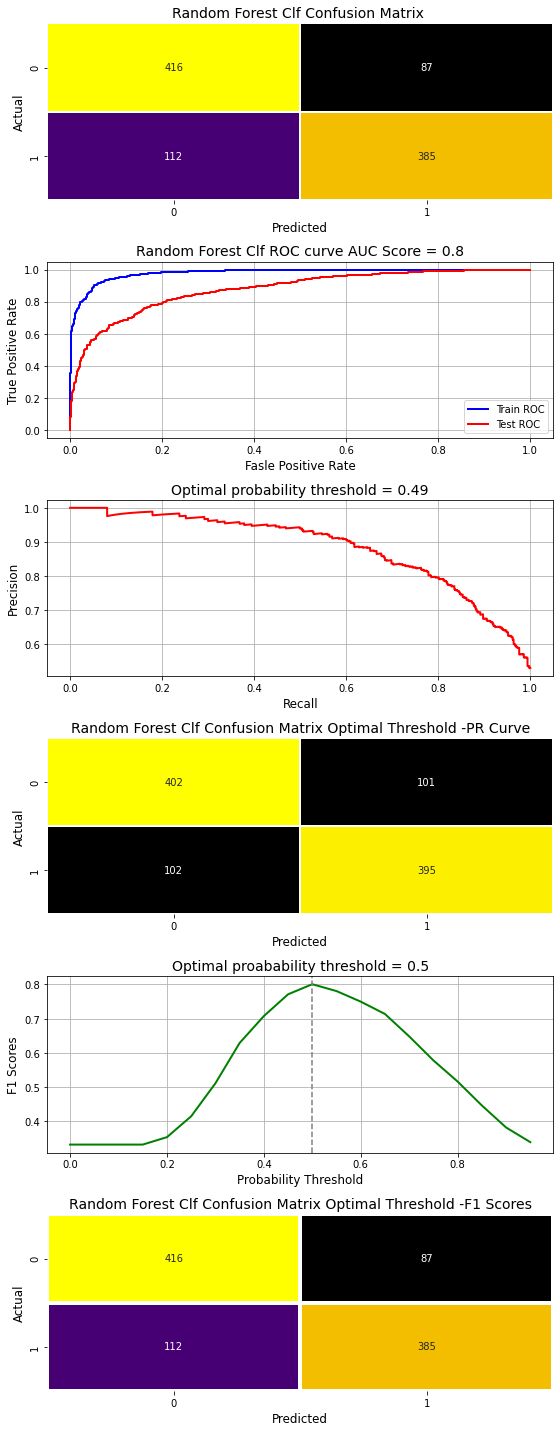

In [30]:
get_model_performance(clf,x_train,x_test,y_train,y_test,plot_title="Random Forest Clf")

Classification report at 0.5 threshold
              precision    recall  f1-score   support

           0       0.86      0.85      0.86       503
           1       0.85      0.86      0.85       497

    accuracy                           0.85      1000
   macro avg       0.85      0.86      0.85      1000
weighted avg       0.86      0.85      0.86      1000

Classification report at optimal threshold from PR curve
              precision    recall  f1-score   support

           0       0.86      0.86      0.86       503
           1       0.85      0.85      0.85       497

    accuracy                           0.85      1000
   macro avg       0.85      0.85      0.85      1000
weighted avg       0.85      0.85      0.85      1000

Classification report at optimal threshold from F1 Scores curve
              precision    recall  f1-score   support

           0       0.85      0.88      0.86       503
           1       0.87      0.84      0.85       497

    accuracy          

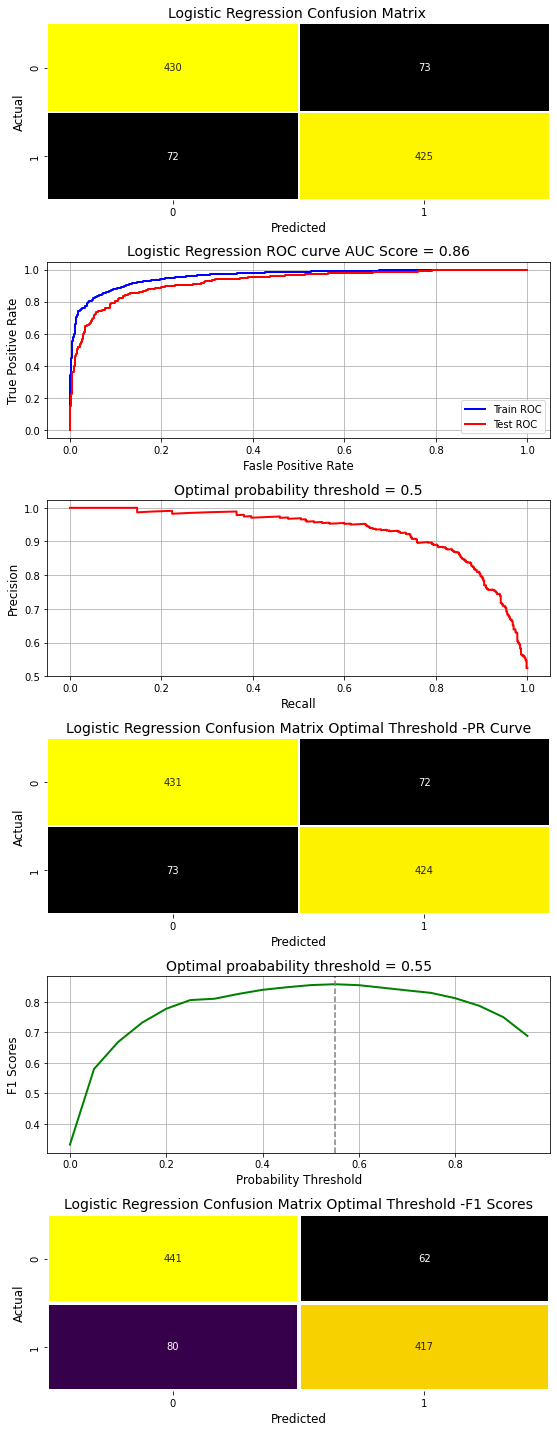

In [31]:
clf = LogisticRegression(random_state=42)
clf.fit(x_train, y_train)
get_model_performance(clf,x_train,
                      x_test,y_train,y_test,plot_title="Logistic Regression")